Most of the code is from [Tutorial from Depends on The Definition](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/) but modified for this final project task and domain.

# Setup and Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%notebook inline

In [ ]:
ROOT_PATH = '/content/drive/My Drive/Tugas/Tugas Semester 8/Tugas Akhir/13516152 - Deborah Aprilia Josephine/';

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 15.2MB/s 
     |████████████████████████████████| 890kB 37.6MB/s 
     |████████████████████████████████| 1.1MB 27.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=4751048fa7402c7ff4de06dd82aef9e349d7ef5533a9aefd81be7a40398d8234
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=985e703ee371d7c3e584abe06eaeba9980bf1c7d5d5f906ad7dc6eb2539efb2c
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [ ]:
import pandas as pd 
import numpy as np
import json
from transformers import BertTokenizer, BertConfig, XLMRobertaTokenizer, XLMRobertaConfig, DistilBertTokenizer, DistilBertConfig
from transformers import BertForTokenClassification, XLMRobertaForTokenClassification, DistilBertForTokenClassification

In [ ]:
model_type = "distilbert"
FINE_TUNING_TYPE = "full"
VERSION = 1
SCENARIO = 2
EPOCH_CONST = 25
BATCH_SIZE = 8
WEIGHT_DECAY_RATE = 0.01
TRAINING_SIZE = 385
TESTING_SIZE = 39

In [ ]:
experiment_information = model_type + "_v" + str(VERSION)
if FINE_TUNING_TYPE == "full" :
  experiment_information += "_full"
elif FINE_TUNING_TYPE == "partial" :
  experiment_information += "_partial"

print ("Info", experiment_information)

training_filename = "scenario-" + str(SCENARIO) + "-train.json"
testing_filename = "scenario-" + str(SCENARIO) + "-test.json"

MODEL_PATH = ROOT_PATH + "model/scenario " + str(SCENARIO) + '/'
RESULT_PATH = ROOT_PATH + "result/scenario " + str(SCENARIO) + '/'
DATASET_PATH = ROOT_PATH + "dataset/version " + str(VERSION) + '/'

print (MODEL_PATH)
print (RESULT_PATH)
print (DATASET_PATH)

Info distilbert_v1_full
/content/drive/My Drive/Tugas/Tugas Semester 8/Tugas Akhir/13516152 - Deborah Aprilia Josephine/model/scenario 2/
/content/drive/My Drive/Tugas/Tugas Semester 8/Tugas Akhir/13516152 - Deborah Aprilia Josephine/result/scenario 2/
/content/drive/My Drive/Tugas/Tugas Semester 8/Tugas Akhir/13516152 - Deborah Aprilia Josephine/dataset/version 1/


# Dataset

In [ ]:
def readJSON(filename) :
  with open(filename, 'r', encoding="utf8") as f:
    obj = json.load(f)
  return obj

def writeJSON(obj, filename) :
  with open(filename, 'w', encoding="utf8") as outfile:
    json.dump(obj, outfile)
  print ("Successfully write JSON obj to", filename)

In [ ]:
LIMIT_SIZE = 5

In [ ]:
training_data = readJSON(DATASET_PATH + training_filename)
print (training_data['tokens_labels'][0][0:LIMIT_SIZE])

testing_data = readJSON(DATASET_PATH + testing_filename)
print (testing_data['tokens_labels'][0][0:LIMIT_SIZE])

[{'token': 'Wardah', 'label': '1-B-Merek'}, {'token': 'Everyday', 'label': '3-B-NamaProduk'}, {'token': 'Cheek', 'label': '3-I-NamaProduk'}, {'token': '&', 'label': '3-I-NamaProduk'}, {'token': 'Liptint', 'label': '3-I-NamaProduk'}]
[{'token': 'Inez', 'label': '1-B-Merek'}, {'token': 'Foundation', 'label': '3-B-NamaProduk'}, {'token': 'Correcting', 'label': '3-I-NamaProduk'}, {'token': 'Cream', 'label': '3-I-NamaProduk'}, {'token': 'Alas', 'label': '2-O'}]


In [ ]:
training_labels = [[object['label'] for object in objects] for objects in training_data["tokens_labels"]]
print (training_labels[0][0:LIMIT_SIZE])
training_sentences = [[object['token'] for object in objects] for objects in training_data["tokens_labels"]]
print (training_sentences[0][0:LIMIT_SIZE])

if TRAINING_SIZE :
  training_labels = training_labels[:TRAINING_SIZE]
  training_sentences = training_sentences[:TRAINING_SIZE]
print ("Jumlah label", str(len(training_labels)), " Jumlah kalimat", str(len(training_sentences)))

['1-B-Merek', '3-B-NamaProduk', '3-I-NamaProduk', '3-I-NamaProduk', '3-I-NamaProduk']
['Wardah', 'Everyday', 'Cheek', '&', 'Liptint']
Jumlah label 385  Jumlah kalimat 385


In [ ]:
testing_labels = [[object['label'] for object in objects] for objects in testing_data["tokens_labels"]]
print (testing_labels[0][0:LIMIT_SIZE])
testing_sentences = [[object['token'] for object in objects] for objects in testing_data["tokens_labels"]]
print (testing_sentences[0][0:LIMIT_SIZE])

if TESTING_SIZE :
  testing_labels = testing_labels[:TESTING_SIZE]
  testing_sentences = testing_sentences[:TESTING_SIZE]
print ("Jumlah label", str(len(testing_labels)), " Jumlah kalimat", str(len(testing_sentences)))

['1-B-Merek', '3-B-NamaProduk', '3-I-NamaProduk', '3-I-NamaProduk', '2-O']
['Inez', 'Foundation', 'Correcting', 'Cream', 'Alas']
Jumlah label 39  Jumlah kalimat 39


In [ ]:
tag2idx = {
    "1-B-Merek" : 1,
    "1-I-Merek" : 2,
    "2-O" : 3,
    "3-B-NamaProduk" : 4,
    "3-I-NamaProduk" : 5,
    "4-B-Varian" : 6,
    "4-I-Varian" : 7,
    "5-B-Ukuran" : 8,
    "5-I-Ukuran" : 9,
    "6-B-Penggunaan" : 10,
    "6-I-Penggunaan" : 11,
    "7-B-Tekstur" : 12,
    "7-I-Tekstur" : 13,
    "PAD" : 14
}

tag2idx2= {
    "B-Merek" : 1,
    "I-Merek" : 2,
    "O" : 3,
    "B-NamaProduk" : 4,
    "I-NamaProduk" : 5,
    "B-Varian" : 6,
    "I-Varian" : 7,
    "B-Ukuran" : 8,
    "I-Ukuran" : 9,
    "B-Penggunaan" : 10,
    "I-Penggunaan" : 11,
    "B-Tekstur" : 12,
    "I-Tekstur" : 13,
    "PAD" : 14
}

tag_values = [tag for tag in tag2idx2.keys()]
print (tag_values)

['B-Merek', 'I-Merek', 'O', 'B-NamaProduk', 'I-NamaProduk', 'B-Varian', 'I-Varian', 'B-Ukuran', 'I-Ukuran', 'B-Penggunaan', 'I-Penggunaan', 'B-Tekstur', 'I-Tekstur', 'PAD']


In [ ]:
if model_type == "xlmr" :
  MODEL_NAME = 'xlm-roberta-base'
  tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
  model = XLMRobertaForTokenClassification.from_pretrained(
      MODEL_NAME,
      num_labels=len(tag2idx),
      output_attentions = False,
      output_hidden_states = False
  )

elif model_type == "mbert" :
  MODEL_NAME = 'bert-base-multilingual-cased'
  tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
  model = BertForTokenClassification.from_pretrained(
      MODEL_NAME,
      num_labels=len(tag2idx),
      output_attentions = False,
      output_hidden_states = False
  )

elif model_type == "distilbert" :
  MODEL_NAME = 'distilbert-base-multilingual-cased'
  tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
  model = DistilBertForTokenClassification.from_pretrained(
      MODEL_NAME,
      num_labels=len(tag2idx),
      output_attentions = False,
      output_hidden_states = False
  )

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You s

In [ ]:
params = list(model.named_parameters())

print('The {:} model has {:} different named parameters.\n'.format(model_type, len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The distilbert model has 102 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (119547, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)
distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight     

In [ ]:
no_decay = ['bias', 'gamma', 'beta']
last_layer = ['classifier.weight']

# Training Setup

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.6.0+cu101'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
MAX_LEN = max(max([len(training_sentence) for training_sentence in training_sentences]), max([len(testing_sentence) for testing_sentence in testing_sentences]))
print ("Token length", MAX_LEN, " Batch size", BATCH_SIZE)

Token length 278  Batch size 8


In [ ]:
training_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(training_sentences, training_labels)
]

training_tokenized_texts = [token_label_pair[0] for token_label_pair in training_tokenized_texts_and_labels]
training_labels = [token_label_pair[1] for token_label_pair in training_tokenized_texts_and_labels]

training_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in training_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

training_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in training_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

training_attention_masks = [[float(i != 0.0) for i in ii] for ii in training_input_ids]

In [ ]:
testing_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(testing_sentences, testing_labels)
]

testing_tokenized_texts = [token_label_pair[0] for token_label_pair in testing_tokenized_texts_and_labels]
testing_labels = [token_label_pair[1] for token_label_pair in testing_tokenized_texts_and_labels]

testing_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in testing_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

testing_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in testing_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

testing_attention_masks = [[float(i != 0.0) for i in ii] for ii in testing_input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(training_input_ids, training_tags,
                                                            random_state=2020, test_size=0.3)
tr_masks, val_masks, _, _ = train_test_split(training_attention_masks, training_input_ids,
                                             random_state=2020, test_size=0.3)

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
tr_tags = torch.tensor(tr_tags)
tr_masks = torch.tensor(tr_masks)

val_inputs = torch.tensor(val_inputs)
val_tags = torch.tensor(val_tags)
val_masks = torch.tensor(val_masks)

test_inputs = torch.tensor(testing_input_ids)
test_tags = torch.tensor(testing_tags)
test_masks = torch.tensor(testing_attention_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

# Training

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'3.0.2'

In [ ]:
model.cuda();

In [ ]:
if FINE_TUNING_TYPE == "full" :
  param_optimizer = list(model.named_parameters())
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': WEIGHT_DECAY_RATE},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
  ]
elif FINE_TUNING_TYPE == "partial":
  param_optimizer = list(model.classifier.named_parameters())
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in last_layer)],
       'weight_decay_rate': 0.0},
      {'params': [torch.tensor(0) for n, p in param_optimizer if any(nd in n for nd in last_layer)],
       'weight_decay_rate': WEIGHT_DECAY_RATE}
  ]
else :
  param_optimizer = list(model.classifier.named_parameters())
  optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

print (FINE_TUNING_TYPE)

full


In [ ]:
from transformers import get_linear_schedule_with_warmup
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * EPOCH_CONST

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
from seqeval.metrics import f1_score, accuracy_score
from seqeval.metrics import classification_report

In [ ]:
loss_values, validation_loss_values, validation_accuracies, validation_f1scores = [], [], [], []

for _ in range(EPOCH_CONST):
    model.train()
    total_loss = 0

    # Training
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        model.zero_grad()
        
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]

        loss.backward()
        total_loss += loss.item()
        
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    loss_values.append(avg_train_loss)

    # Validation
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))

    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                for p_i, l_i in zip(p, l) if tag_values[l_i - 1] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i - 1] != "PAD"]
    
    print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    validation_accuracies.append(accuracy_score(valid_tags, pred_tags))
    
    print("Validation F1-Score: {}".format(f1_score(valid_tags, pred_tags)))
    validation_f1scores.append(f1_score(valid_tags, pred_tags))
    
    print (classification_report(valid_tags, pred_tags))
    print()

Average train loss: 0.9423719889977399
Validation loss: 0.48477982878685
Validation Accuracy: 0.8560485157995531
Validation F1-Score: 0.8629560141755265
            precision    recall  f1-score   support

NamaProduk       0.93      0.96      0.94      9732
     Merek       0.28      0.17      0.21       191
Penggunaan       1.00      0.29      0.45       226
    Ukuran       0.14      0.04      0.07       369
    Varian       0.45      0.83      0.58      1066
   Tekstur       0.00      0.00      0.00        34
       PAD       0.00      0.00      0.00         4

 micro avg       0.84      0.89      0.86     11622
 macro avg       0.85      0.89      0.86     11622


Average train loss: 0.2960810933042975
Validation loss: 0.20692121336857477
Validation Accuracy: 0.947015639961698
Validation F1-Score: 0.9467395015363604
            precision    recall  f1-score   support

NamaProduk       0.95      0.99      0.97      9732
     Merek       0.89      0.95      0.92       191
Penggunaan 

In [ ]:
import datetime
torch.save(model, MODEL_PATH + experiment_information + ".pth")
# torch.save(model, MODEL_PATH + experiment_information + "-" + str(datetime.datetime.now().time()) + ".pth")

In [ ]:
metrics = {}
metrics_training = {}
metrics_training['loss-values'] = loss_values
metrics_training['validation-loss'] = validation_loss_values
metrics_training['validation-accuracy'] = validation_accuracies
metrics_training['validation-f1'] = validation_f1scores
metrics_training['classification_report'] = classification_report(valid_tags, pred_tags)

metrics['training'] = metrics_training

for key, values in metrics.items() :
  print (key, len(values))

training 5


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


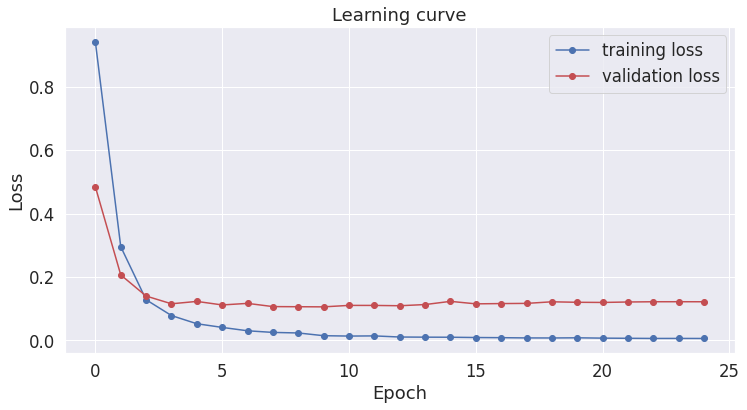

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
model.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

eval_loss = eval_loss / len(test_dataloader)
validation_loss_values.append(eval_loss)
print("Validation loss: {}".format(eval_loss))

pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                            for p_i, l_i in zip(p, l) if tag_values[l_i - 1] != "PAD"]
valid_tags = [tag_values[l_i] for l in true_labels
                              for l_i in l if tag_values[l_i - 1] != "PAD"]

print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
validation_accuracies.append(accuracy_score(valid_tags, pred_tags))

print("Validation F1-Score: {}".format(f1_score(valid_tags, pred_tags)))
validation_f1scores.append(f1_score(valid_tags, pred_tags))

print (classification_report(valid_tags, pred_tags))
print()

print (pred_tags[0:LIMIT_SIZE])

print (valid_tags[0:LIMIT_SIZE])

Validation loss: 0.5787165582180023
Validation Accuracy: 0.8807327358987875
Validation F1-Score: 0.8904955777060227
            precision    recall  f1-score   support

Penggunaan       0.92      0.65      0.76        74
NamaProduk       0.93      0.93      0.93      5770
    Varian       0.76      0.86      0.81       923
   Tekstur       0.26      0.62      0.37         8
    Ukuran       0.70      0.48      0.57       238
     Merek       0.70      0.11      0.18       151

 micro avg       0.90      0.89      0.89      7164
 macro avg       0.89      0.89      0.88      7164


['I-Merek', 'I-Merek', 'I-NamaProduk', 'B-Varian', 'B-Varian']
['I-Merek', 'I-Merek', 'I-NamaProduk', 'B-Varian', 'B-Varian']


In [ ]:
metrics_testing = {}
metrics_testing['loss-values'] = loss_values
metrics_testing['validation-loss'] = validation_loss_values
metrics_testing['validation-accuracy'] = validation_accuracies
metrics_testing['validation-f1'] = validation_f1scores
metrics_testing['classification_report'] = classification_report(valid_tags, pred_tags)

metrics['testing'] = metrics_testing

In [ ]:
writeJSON(metrics, RESULT_PATH + experiment_information + ".json")
# writeJSON(metrics, RESULT_PATH + experiment_information + "-" + str(datetime.datetime.now().time()) + ".json")

Successfully write JSON obj to /content/drive/My Drive/Tugas/Tugas Semester 8/Tugas Akhir/13516152 - Deborah Aprilia Josephine/result/scenario 2/distilbert_v1_full.json
